In [40]:
from surprise.model_selection import train_test_split
from surprise import KNNBasic, accuracy
from surprise import Dataset, Reader
from surprise.dump import dump

from recmetrics import rmse, mse, mark, mark_plot

from os.path import join, split
from random import sample

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
_HERE = ''
dataset_path = join(_HERE, '..', '..', 'dataset', 'movielens', 'ratings.csv')
dataset_path

'../../dataset/movielens/ratings.csv'

# Read dataset

In [21]:
ratings = pd.read_csv(dataset_path)
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


# k-NN Model training

In [3]:
reader = Reader(line_format='user item rating timestamp', sep=',' , rating_scale=(0.5, 5), skip_lines=162541*150)
data = Dataset.load_from_file(dataset_path, reader=reader)
trainset, testset = train_test_split(data, test_size=.25)

In [4]:
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(k=2, sim_options=sim_options, verbose=True)

In [5]:
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [44]:
preds = algo.test(testset, verbose=False)

In [45]:
preds = pd.DataFrame(preds)
preds.drop("details", inplace=True, axis=1)
preds.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
preds.head()

,userId,movieId,actual,cf_predictions
0,160210,4022,2.0,3.000000
1,160933,4776,4.0,2.748980
2,161298,780,2.0,3.499992
3,159269,40732,4.5,3.250000
4,159504,7983,4.5,4.000000


# Recommendations

In [43]:
cf_model = preds.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)
cf_model.head()

movieId,1,10,100,100036,100058,100060,100083,100106,100108,100159,...,99839,99841,999,99906,99910,99912,99917,99968,99986,99996
userId,,,,,,,,,,,,,,,,,,,,,
158413,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158414,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158415,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158416,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158417,0.0,3.249375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
test = preds.copy().groupby('userId', as_index=False)['movieId'].agg({'actual': (lambda x: list(set(x)))})
test = test.set_index("userId")
test.head()

,actual
userId,
158413,"[34162, 8781, 7153, 2150, 1884, 2022, 3424, 38..."
158414,"[81834, 141, 2424, 8464, 628, 260, 54286, 5008..."
158415,"[5459, 5724, 40815, 2136]"
158416,"[5553, 6, 4889, 3256, 1676, 2291, 3363, 858, 1..."
158417,"[590, 51077, 1036, 2, 150, 47200, 1923, 2797, ..."


# k-NN recommendations

In [15]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [18]:
# make recommendations for all members in the test data
cf_recs = [] = []
for user in tqdm(test.index, desc='k-NN recommendations', total=len(test.index)):
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions
userId,,
158413,"[34162, 8781, 7153, 2150, 1884, 2022, 3424, 38...","[3267, 3362, 1884, 1569, 3633, 8781, 3274, 194..."
158414,"[81834, 141, 2424, 8464, 628, 260, 54286, 5008...","[2424, 260, 91630, 8464, 8665, 141, 96079, 542..."
158415,"[5459, 5724, 40815, 2136]","[5724, 40815, 5459, 2136, 1, 5530, 55280, 5528..."
158416,"[5553, 6, 4889, 3256, 1676, 2291, 3363, 858, 1...","[6, 2291, 1729, 858, 3256, 5553, 4889, 1676, 3..."
158417,"[590, 51077, 1036, 2, 150, 47200, 1923, 2797, ...","[47200, 21, 51077, 296, 5952, 541, 4985, 10, 1..."


# Popularity-based recommendations

In [22]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

pop_recs = []
for user in tqdm(test.index, desc='Popularity-based recommendations', total=len(test.index)):
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
158413,"[34162, 8781, 7153, 2150, 1884, 2022, 3424, 38...","[3267, 3362, 1884, 1569, 3633, 8781, 3274, 194...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959..."
158414,"[81834, 141, 2424, 8464, 628, 260, 54286, 5008...","[2424, 260, 91630, 8464, 8665, 141, 96079, 542...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959..."
158415,"[5459, 5724, 40815, 2136]","[5724, 40815, 5459, 2136, 1, 5530, 55280, 5528...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959..."
158416,"[5553, 6, 4889, 3256, 1676, 2291, 3363, 858, 1...","[6, 2291, 1729, 858, 3256, 5553, 4889, 1676, 3...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959..."
158417,"[590, 51077, 1036, 2, 150, 47200, 1923, 2797, ...","[47200, 21, 51077, 296, 5952, 541, 4985, 10, 1...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959..."


# Random recommendations

In [27]:
# make recommendations for all members in the test data

ran_recs = []
movies = set(ratings.movieId.values.tolist())

for user in tqdm(test.index, desc='Random recommendations', total=len(test.index)):
    random_predictions = sample(movies, 10)
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

Random recommendations: 100%|██████████| 4129/4129 [00:07<00:00, 582.88it/s]


,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
158413,"[34162, 8781, 7153, 2150, 1884, 2022, 3424, 38...","[3267, 3362, 1884, 1569, 3633, 8781, 3274, 194...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[45, 158890, 147942, 141321, 126558, 133339, 1..."
158414,"[81834, 141, 2424, 8464, 628, 260, 54286, 5008...","[2424, 260, 91630, 8464, 8665, 141, 96079, 542...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[82527, 7204, 32082, 152332, 146497, 36523, 55..."
158415,"[5459, 5724, 40815, 2136]","[5724, 40815, 5459, 2136, 1, 5530, 55280, 5528...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[178315, 194961, 161056, 7170, 48389, 194636, ..."
158416,"[5553, 6, 4889, 3256, 1676, 2291, 3363, 858, 1...","[6, 2291, 1729, 858, 3256, 5553, 4889, 1676, 3...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[142428, 140988, 79139, 73015, 3779, 100251, 5..."
158417,"[590, 51077, 1036, 2, 150, 47200, 1923, 2797, ...","[47200, 21, 51077, 296, 5952, 541, 4985, 10, 1...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[193565, 102245, 153338, 86440, 57692, 161119,..."


# Model Evaluation

In [28]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [35]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [36]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [37]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.08090895013568725,
 0.15939600635032825,
 0.23449241107550445,
 0.3040184597822743,
 0.3677319630785331,
 0.42408290885481126,
 0.47175540141400707,
 0.512439000086755,
 0.5474614217190574,
 0.5784473534829493]

In [42]:
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
158413,"[34162, 8781, 7153, 2150, 1884, 2022, 3424, 38...","[3267, 3362, 1884, 1569, 3633, 8781, 3274, 194...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[45, 158890, 147942, 141321, 126558, 133339, 1..."
158414,"[81834, 141, 2424, 8464, 628, 260, 54286, 5008...","[2424, 260, 91630, 8464, 8665, 141, 96079, 542...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[82527, 7204, 32082, 152332, 146497, 36523, 55..."
158415,"[5459, 5724, 40815, 2136]","[5724, 40815, 5459, 2136, 1, 5530, 55280, 5528...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[178315, 194961, 161056, 7170, 48389, 194636, ..."
158416,"[5553, 6, 4889, 3256, 1676, 2291, 3363, 858, 1...","[6, 2291, 1729, 858, 3256, 5553, 4889, 1676, 3...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[142428, 140988, 79139, 73015, 3779, 100251, 5..."
158417,"[590, 51077, 1036, 2, 150, 47200, 1923, 2797, ...","[47200, 21, 51077, 296, 5952, 541, 4985, 10, 1...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[193565, 102245, 153338, 86440, 57692, 161119,..."


In [52]:
print("MSE: ", mse(preds.actual, preds.cf_predictions))
print("RMSE: ", rmse(preds.actual, preds.cf_predictions))

MSE:  1.4470384238070022
RMSE:  1.2029291017375057


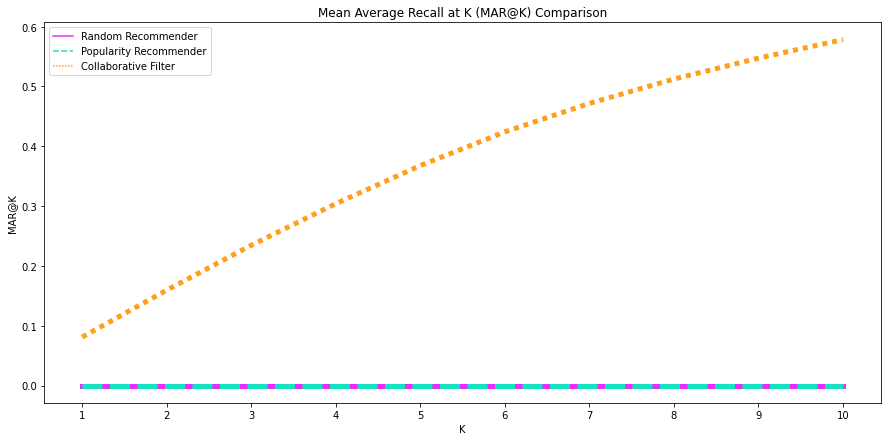

In [41]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,11)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
mark_plot(mark_scores, model_names=names, k_range=index)

# Saving predictions & model

In [51]:
dumping_path = join(_HERE, '..', '..', 'artifacts', 'k-nn.dump')
dump(dumping_path, preds, algo, verbose=1)

The dump has been saved as file ../../artifacts/k-nn.dump
